In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pywt.data
import sys
import cv2

if '..' not in sys.path:
    sys.path.append('..')

from stego.transform import blocking, dwt

In proposed MDLE-IWT method, 
1. IWT is first appliedto the cover image to obtain four wavelet coefficient sub-bands asembedding regions.
1. The embedding sub-bands order in the algorithm is HL, LH, HH, and LL. 
1. Next, the embedding sub-band is divided into 3×3 non-overlapping blocks
1. MDLE scheme is applied to each block


In [2]:
coeffs_order = [(0,0),(0,1),(0,2),(1,2),(2,2),(2,1),(2,0),(1,0)]
def is_edge_block(block, T=4):
    U = []
    center = block[1,1]
    for idx in coeffs_order:
        di = abs(center-block[idx])
        U.append(di)
        # print(f'{block[idx]=}')
    V = max(U)/4
    C = 0
    for g in U:
        if g >= V:
            C += 1
    return C > T

def extraction_function(pi, pc):
    return (pi + pc) % 4

def lcv(S, f):
    return (S - f) % 4

lcv_to_mv = [0, 1, 2, -1]

def byte_to_dec_array(byte):
    result = [None,None,None, None]
    result[0] = (byte & 0b11000000) >> 6
    result[1] = (byte & 0b00110000) >> 4
    result[2] = (byte & 0b00001100) >> 2
    result[3] = (byte & 0b00000011)

    return result

def dec_array_to_byte(encoded_data):
    result = 0
    result |= int(encoded_data[0]) << 6
    result |= int(encoded_data[1]) << 4
    result |= int(encoded_data[2]) << 2
    result |= int(encoded_data[3])
    
    return result


def embed(block, decimal_data: np.ndarray):
    center_coeff = block[1,1]
    perimiter_coeffs = np.array([block[idx] for idx in coeffs_order])
    lcvs = lcv(decimal_data, extraction_function(perimiter_coeffs, center_coeff))
    mvs = [lcv_to_mv[int(lcv)] for lcv in lcvs]

    for idx, mv in zip(coeffs_order, mvs):
        block[idx] += mv

    return block

def extract(block):
    center_coeff = block[1,1]
    perimiter_coeffs = np.array([block[idx] for idx in coeffs_order])
    return extraction_function(perimiter_coeffs, center_coeff)

In [3]:
original = pywt.data.camera()
original = blocking.pad_image(original, 5)
iwt = dwt.Iwt('haar')

In [4]:
iwt.forward(original)
detail_coefficients: list[np.ndarray] = iwt.coefficients[1]

In [5]:
detail_coefficients_blocks = [blocking.divide_image(coeff, block_size=3) for coeff in detail_coefficients]

In [6]:
secret_message = "Secret message to be saved"
byte_message = bytes(secret_message, 'utf-8')
n2 = []
for b in byte_message:
    n2.extend(byte_to_dec_array(b))

In [7]:

for i, band in enumerate(detail_coefficients_blocks):
    for j, row in enumerate(band):
        for k, block in enumerate(row):
            if len(n2) <= 8:
                decimal_data = [0,0,0,0,0,0,0,0]
                decimal_data = n2 + decimal_data[len(n2):]
                detail_coefficients_blocks[i][j][k] = embed(block, decimal_data)
                break
            decimal_data = np.array(n2[:8])
            n2 = n2[8:]
            print(decimal_data)
            detail_coefficients_blocks[i][j][k] = embed(block, decimal_data)
            

[1 1 0 3 1 2 1 1]
[1 2 0 3 1 3 0 2]
[1 2 1 1 1 3 1 0]
[0 2 0 0 1 2 3 1]
[1 2 1 1 1 3 0 3]
[1 3 0 3 1 2 0 1]
[1 2 1 3 1 2 1 1]
[0 2 0 0 1 3 1 0]
[1 2 3 3 0 2 0 0]
[1 2 0 2 1 2 1 1]
[0 2 0 0 1 3 0 3]
[1 2 0 1 1 3 1 2]


In [8]:
iwt.coefficients[1] = detail_coefficients

stego_img = iwt.inverse()
stego_img.shape

(516, 516)

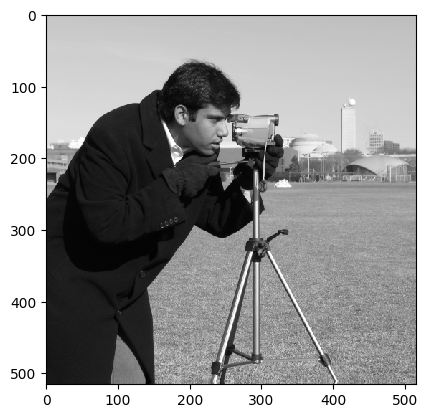

In [9]:

plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
# cv2.imwrite("comp.jpg", stego_img)
# img = cv2.imread("comp.jpg")
# stego_img, g, b = cv2.split(img)
# stego_img.shape

## Extracting

In [10]:
# extract
iwt.forward(stego_img)
detail_coefficients = iwt.coefficients[1]

detail_coefficients_blocks = [blocking.divide_image(coeff, block_size=3) for coeff in detail_coefficients]


In [11]:
encoded_data = []
for i, band in enumerate(detail_coefficients_blocks):
    for j, row in enumerate(band):
        for k, block in enumerate(row):
            encoded_data.extend(extract(block))
encoded_data = [int(i) for i in encoded_data]

In [12]:
chunks = [encoded_data[x:x+4] for x in range(0, len(encoded_data), 4)]

In [13]:
dec_list = []
for chunk in chunks:
    dec_list.append(dec_array_to_byte(chunk))

In [14]:
bytes(dec_list)[:50]

b'Secret message to be savedE\xf8\xc31\xf9\xcb\xd1\r3\x00\xef\xfan\xe5D\xd51\xc8\x88{>\xd9\xcf\xea'